# Tutorial 22: Numerical Solution of PDEs

## PHYS 5070, Spring 2022

In [3]:
## Common import cell!

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## T22.1 - Boundary-value PDEs with over-relaxation

Continuing from lecture, we'll solve the Poisson equation in CGS units in two dimensions:

\\[
\frac{\partial^2 U}{\partial x^2} + \frac{\partial^2 U}{\partial y^2} = -4\pi \rho(x,y).
\\]

The discrete version appropriate for relaxation is

\\[
U_{i,j} = \pi \Delta^2 \rho_{i,j} + \frac{1}{4} \left[ U_{i,j+1} + U_{i,j-1} + U_{i+1,j} + U_{i-1,j} \right].
\\]

### Part A

We'll use the __over-relaxation__ method as discussed in lecture.  Once again, defining the residual $r_{i,j}$ to be the difference between the left and right-hand sides of the above equation (_careful with the sign!_), our proposed update step for each sweep through the potential field is

\\[
U'_{i,j} = U_{i,j} + \omega r_{i,j}
\\]

with the relaxation parameter $1 < \omega < 2$.

To implement this algorithm, we need to decide on some implementation details.  We'll use a 2d NumPy array to represent $U_{i,j}$, and update the array in-place with each step.  Normally, I always tell you to avoid `for` loops when working with NumPy; in this particular case, you should use two `for` loops to sweep through `i` and `j` sequentially, so that the updated potential grid is used for the next step.

Finally, we need to implement _boundary conditions_, surfaces on which the potential is held fixed.  A simple way to do this is with a mask: anywhere the `on_boundary` mask is `True`, we'll simply skip the update step.  (This only accommodates Dirichlet boundary conditions, but that's good enough for this tutorial.)

__Implement the function `poisson_OR_sweep`__ in the cell below, which should return the updated $U'_{i,j}$ after a single overrelaxation sweep is applied.  Make sure you use the `on_boundary` mask so that your algorithm knows where the fixed boundaries are and doesn't try to update them.  As long as you do this (and the mask covers all four edges properly), you shouldn't run into problems with running arrays out of bounds.

In [23]:
def poisson_OR_sweep(U, on_boundary, Delta, omega=1.5, rho=None):
    """
    Carries out a single sweep of over-relaxation to solve the 
    Poisson equation in two dimensions.
        
    Inputs:
        - U: 2d NumPy array containing the potential U(x,y)
             on a discrete grid.
        - on_boundary: 2d NumPy array, same shape as U.
             "True" for points lying on Dirichlet boundaries,
             which should *not* be updated by the sweep.
        - Delta: float, grid spacing used for U.
        - omega: float, default 1.5, overrelaxation parameter
        - rho: optional 2d NumPy array, same shape as U.
                Discretized source charge density.
                
    Outputs:
        Nothing!  U is modified in-place (mutated.)
    
    """
    
    
    if rho is None:
        rho = np.zeros_like(U)
        
    ### BEGIN SOLUTION
    
    Ni = U.shape[0]
    Nj = U.shape[1]  
    
    for i in range(Ni):
        for j in range(Nj):
            
            if not on_boundary[i,j]:
                r = U[i,j] - (U[i,j+1] + U[i,j-1] + U[i+1,j] + U[i-1,j]) / 4 - np.pi * Delta**2 * rho[i,j]
                U[i,j] -= omega * r
    ### END SOLUTION

    return
        

Let's test a single step of the algorithm with a simple test case.  We'll initialize a 3x3 grid with two points in the bottom-right corner set to $U_0 = 1$.  It should be easy to see that the single point not on the boundary which is adjacent to both will be updated to $1.5 (1+1)/4 = 3/4$.

In [24]:
import numpy.testing as npt

U_test = np.zeros((4,4))
U_test[2,3] = 1
U_test[3,2] = 1

# Create boundary mask
m_test = np.ones_like(U_test)
m_test[1:3,1:3] = 0

print(U_test)

poisson_OR_sweep(U_test, m_test, Delta=1)

npt.assert_allclose(U_test, np.array([
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0.75,1],
    [0,0,1,0],
]))

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


### Part B

Now we'll complete our algorithm by putting it in a loop.  First, we'll need a function that computes the global residual, i.e. the tensor $r_{i,j}$ across our entire grid.  I'll just give you this one:

In [25]:
def global_residual(U, Delta, rho=None):
    if rho is None:
        rho = np.zeros_like(U)
        
    neighbors = np.roll(U, 1, axis=0) + np.roll(U, -1, axis=0) + np.roll(U, 1, axis=1) + np.roll(U, -1, axis=1)
    
    return U - np.pi * Delta**2 * rho - neighbors / 4

Instead of just stopping after a fixed number of iterations, we'll do something a little more sophisticated and set a __stopping condition__.  We'll use the global residual function above: if the _volume-averaged root mean square residual_ $\sqrt{\sum_{i,j} r_{ij}^2} / V$ (where $V = L^2$) on our grid is less than some given number `atol` (the _tolerance_), then we'll stop.  To avoid infinite loops, we'll also set a maximum number of allowed steps.

I've given you the function to compute the global RMS residual, and the start of the Poisson solver; __finish the implementation__.  Remember, the solution should step when `atol` is reached by the residual or when `max_sweeps` is reached, whichever happens first.

In [26]:
def total_residual_RMS(U, on_boundary, Delta, rho):
    # Ensure on_boundary is a mask
    on_boundary = np.asarray(on_boundary, bool)
    
    rij = global_residual(U, Delta=Delta, rho=rho)
    rij_masked = rij[~on_boundary]
    
    return np.sqrt(np.sum(rij_masked**2))
    
    
    
def solve_poisson_OR(U, on_boundary, Delta, omega=1.5, rho=None, atol=1e-6, max_sweeps=200):

    if rho is None:
        rho = np.zeros_like(U)
        
    V = U.shape[0] * U.shape[1]
    
    # Compute residual
    r_tot = total_residual_RMS(U, on_boundary, Delta, rho) / V
    n_sweeps = 0
    
    ### BEGIN SOLUTION
    while (r_tot > atol) and (n_sweeps < max_sweeps):
        poisson_OR_sweep(U, on_boundary, Delta, omega=omega, rho=rho)
        
        r_tot = total_residual_RMS(U, on_boundary, Delta, rho) / V
        
        n_sweeps += 1
    
    
    ### END SOLUTION

    return (r_tot, n_sweeps)

Let's try a trivial test case before we move on: if we have a completely grounded box ($U=0$ on all four walls), then the potential should be zero inside.  We'll start with a non-zero initial potential in the center and make sure it converges to the correct solution.  __Run the cell below__ (read carefully first!) to set up the grid, potential, and boundary mask.  I've also given you a couple of convenience functions for plotting potential and mask which you'll run below.  

(The book likes 3-d wireframe plots, but I think those are hard to read - I strongly prefer contour plots where the third axis is denoted using color.  See here for more info on these sort of contour plots in Matplotlib: https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html.)

In [27]:
# Box size of 20
L = 20
x, y = np.meshgrid(np.arange(L), np.arange(L), indexing='ij')

# Note: dtype argument is important since x is an int array.
# We don't want to restrict our potential to integer values!
U = np.zeros_like(x, dtype=np.float64)
box_mask = np.zeros_like(U, dtype=bool)

# Initialize non-zero potential in the middle
U[8:12,8:16] = 1

# Set mask to cover the four walls of the box
box_mask[0,:] = True
box_mask[L-1,:] = True
box_mask[:,0] = True
box_mask[:,L-1] = True

def show_potential(x,y,U, **kwargs):
    plt.contourf(x,y,U, **kwargs)
    plt.colorbar()
    ax = plt.gca()
    ax.set_aspect(1)
    
def show_mask(x,y,m):
    plt.contourf(x,y,m)
    ax = plt.gca()
    ax.set_aspect(1)

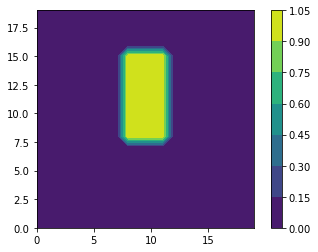

In [28]:
show_potential(x,y,U)

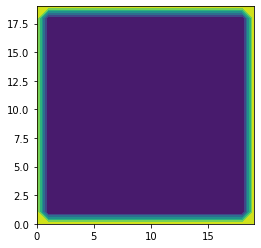

In [29]:
show_mask(x,y,box_mask)

Now __run the final cell below__ to test your solution implementation - you should see in the final plot that indeed $U$ has been zeroed out everywhere in the box.

Final RMS residual:  9.276005086006913e-09
Number of sweeps:  110


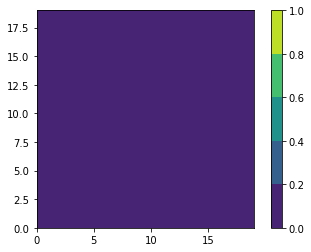

In [30]:
final_r, Nsweeps = solve_poisson_OR(U, box_mask, Delta=1, atol=1e-8)
show_potential(x,y,U, levels=[0,0.2,0.4,0.6,0.8,1])

print("Final RMS residual: ", final_r)
print("Number of sweeps: ", Nsweeps)

npt.assert_allclose(final_r, 0, atol=2e-8)

# Check that max_sweeps works correctly
U[8:12,8:12] = 1
test_r, Nsweeps = solve_poisson_OR(U, box_mask, Delta=1, atol=1e-6, max_sweeps=10)
assert abs(Nsweeps - 10) <= 1

### Part C

Now let's run a more non-trivial test case, borrowed from the textbook.  Once again we'll solve for the potential inside a box, but now we'll take the number of grid points to be $L=100$, once again with $\Delta = 1$ for simplicity.  This time, three of the four walls will be held at $U=0$, but the top wall of the box at $y=L$ will be held at $U_0 = 100$ V.

In [31]:
L = 100
x, y = np.meshgrid(np.arange(L), np.arange(L), indexing='ij')

Now we'll hold the top row ($y=99$) at constant potential $U_0 = 100$ V, and all other sides 0 V, remembering to mark all boundaries with a mask.  __Finish the function below__, which should initialize `U` and the boundary mask `box_mask` (you can follow my example from part B.)

247.48737341529164


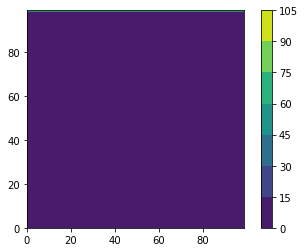

In [32]:
def setup_potential_partC(x, V0=100):

    U = np.zeros_like(x, dtype=np.float64)
    box_mask = np.zeros_like(U, dtype=bool)
    
    ### BEGIN SOLUTION
    U[:,L-1] = V0
    box_mask[0,:] = True
    box_mask[L-1,:] = True
    box_mask[:,0] = True
    box_mask[:,L-1] = True

    ### END SOLUTION
    
    return U, box_mask

U, box_mask = setup_potential_partC(x)
print(total_residual_RMS(U, box_mask, 1, None))
show_potential(x,y,U)

This problem will be much harder to solve than the simple empty box we tried above.  Before we try to find a full solution, let's try to __tune our over-relaxation parameter__ $\omega$.  In the cell below, run several test solutions of 200 sweeps, varying $\omega$ in the range $1 < \omega < 2$.  Make a plot of the final residual vs. $\omega$ - we'll choose the value which gives the smallest residual for the next part.

_Don't forget_ to reset the potential for each $\omega$ that you test - remember that we're modifying $U$ in place, so if you don't reset the larger $\omega$ values will look much better than they should as you start with the previous solution!

(This cell may take a couple of minutes to run.  If it's taking too long, you can skip this step and just plug in some value between $1.5$ and $1.9$.  Avoid $\omega \geq 2$, which will cause severe instability for this problem and solver.)

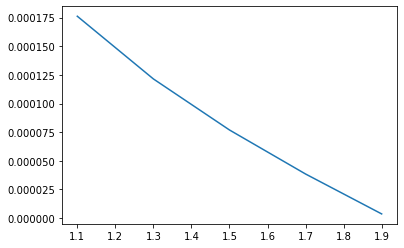

In [33]:
test_max = 200
omega_range = np.linspace(1.1,1.9,5)
resids = []

for om in omega_range:
    U, box_mask = setup_potential_partC(x)
    test_r, _ = solve_poisson_OR(U, box_mask, Delta=1, omega=om, max_sweeps=test_max)
    resids.append(test_r)
    
plt.plot(omega_range, resids)

Now using the optimized value of $\omega$ from your test above, __run the solver__ to find a solution for the electric potential.  You're free to adjust the `atol` and `max_sweeps` parameters; you'll probably come back here to make further adjustments from part C below.

Final RMS residual:  9.941539954135934e-08
Number of sweeps:  369


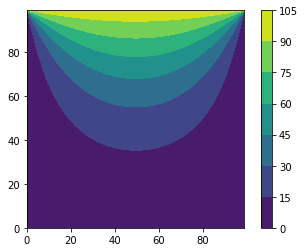

In [34]:
U, box_mask = setup_potential_partC(x, V0=100)

final_r, Nsweeps = solve_poisson_OR(U, box_mask, Delta=1, omega=1.9, atol=1e-7, max_sweeps=1500)
show_potential(x,y,U)

print("Final RMS residual: ", final_r)
print("Number of sweeps: ", Nsweeps)

This is a simple enough system that there is an analytic solution for the potential as a Fourier series,

\\[
U(x,y) = \sum_{n=1,3,5...}^\infty \frac{400}{\pi n} \sin \left( \frac{n \pi x}{L} \right) \frac{\sinh(n\pi y/L)}{\sinh(n\pi)}.
\\]

where again $L = 100$ is the box size.  Although this is a nice closed-form solution, in practice we have to truncate the Fourier series somewhere to evaluate it numerically - and we will need a surprisingly large number of terms to get an accurate solution compared to our over-relaxation results!

There is another numerical problem hidden here, which is that the $\sinh(x)$ function grows very quickly with its argument.  The $y$-direction solution thus has an enormous cancellation between the numerator and denominator which will quickly become unstable even with double precision.  As the book points out, the best way around this is to replace the fraction with its asymptotic version when $n$ is sufficiently large:

\\[
\frac{\sinh(n\pi y/L)}{\sinh(n\pi)} \rightarrow_{n \rightarrow \infty} e^{n\pi (y/L - 1)}.
\\]

This function is well-behaved since $0 \leq y/L \leq 1$.  __Implement the function `box_U_analytic()`__ in the cell below, which should return a U array (of the same form as the ones we've been using for our numerics above) keeping all terms in the Fourier series with $n < N$.

In [35]:
def box_U_analytic(N, x, y, L=100):
    U_pred = np.zeros_like(x, dtype=np.float64)
    
    ### BEGIN SOLUTION
    
    for n in np.arange(1,N,2):
        x_term = np.sin(n * np.pi * x / L)
        if (n < 50):
            y_term = np.sinh(n * np.pi * y / L ) / np.sinh(n * np.pi)
        else:
            y_term = np.exp(n * np.pi * (y/L - 1))
            
        U_pred += 400 / (np.pi * n) *  x_term * y_term

    ### END SOLUTION
        
    return U_pred

__Run the cell below__ to plot your analytic solution; it should look similar to the final plot you ended up with above using over-relaxation.  If the plot is rotated, you may have created an array with the `x` and `y` coordinates swapped (as noted above, the NumPy row-major index conventions make this easy to do.)  If so, use `U_pred = U_pred.T` to transpose the array before you return it.

Explore how large `N` needs to be in order to show good agreement with your other solution, both over the whole box and in the slices shown in the following cells.  You can go back and adjust your numerical solution's stopping conditions to try to improve the agreement.

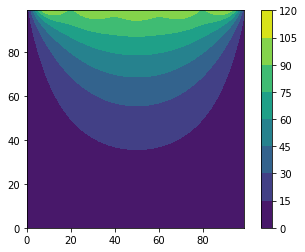

In [36]:
U_analytic = box_U_analytic(10, x, y)
show_potential(x,y,U_analytic)

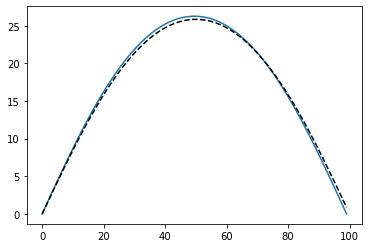

In [37]:
plt.plot(x[:,51], U[:,51])
plt.plot(x[:,51], U_analytic[:,51], linestyle='--', color='k')

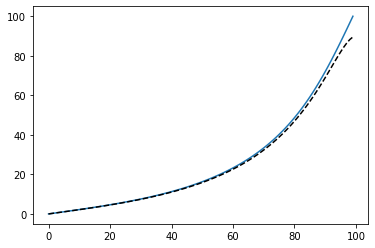

In [38]:
plt.plot(y[21,:], U[21,:])
plt.plot(y[21,:], U_analytic[21,:], linestyle='--', color='k')

### Part D (optional)

Since you went to the trouble of including the charge density term, let's look at one final solution.  Put a line charge with total $Q=+20$ down the center of your box (i.e. at $x=50$), and then solve for the modified potential.   You should see obvious effects from both the constant-potential boundary and from the line charge in the resulting solution plot.



Final RMS residual:  9.95791326816681e-07
Number of sweeps:  279


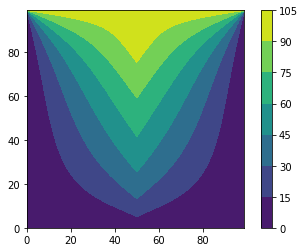

In [39]:
U, box_mask = setup_potential_partC(x)
rho_line = np.zeros_like(U)

rho_line[50,:] = 20/L

final_r, Nsweeps = solve_poisson_OR(U, box_mask, Delta=1, omega=1.9, atol=1e-6, max_sweeps=600, rho=rho_line)
show_potential(x,y,U)

print("Final RMS residual: ", final_r)
print("Number of sweeps: ", Nsweeps)

One final note: this is one of the more computationally intensive tutorials we've done, because we wrote a double `for` loop in Python for the overrelaxation sweep itself.  However, there are ways to greatly speed up the solution using _just-in-time compilation_, which moves the `for` loop into a compiled bit of code (instead of interpreted, as Python code usually is.)

If you have some time left, try to download the [Numba](https://numba.pydata.org) module with `pip install numba`, and look into the `numba.jit` function to see if you can accelerate your `poisson_OR_sweep` function and speed up your solutions.  (We'll see another module next week, JAX, which can also do JIT compilation among other features very useful for machine learning.))